In [10]:
# for CKA
import random
import gc
import os
import numpy as np
import pickle
import gzip
import cca_core
from CKA import linear_CKA, kernel_CKA

# for model
import torch
import torchvision

import torch.nn as nn
from torchvision import transforms as T
from torchvision.models import resnet50
import cv2
import random
import math
import pandas as pd
from PIL import Image

device = "cuda:0" 

In [11]:
# use fixed seed
manual_seed = 42
print("Random Seed: ", manual_seed)
random.seed(manual_seed)
torch.manual_seed(manual_seed)
torch.cuda.manual_seed_all(manual_seed)

Random Seed:  42


In [12]:
def test_dataloader():

    transform_test = T.Compose([
        T.Resize((550, 550)),
        T.CenterCrop(448),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    
    #ImageFile.LOAD_TRUNCATED_IMAGES = True
    testset = torchvision.datasets.ImageFolder(root='../../dataset/Accida_classification/split_dataset_v5_normal_strong_100/Test',transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, shuffle=False, num_workers=4,  batch_size=4) # batch_size = 16

    return testset, testloader


In [13]:
image_datasets, dataloaders = test_dataloader()

In [14]:
dataloaders

### #1. CKA Tutorial codes

In [12]:
# load the pretrained models
net = resnet50(pretrained = False)
best_checkpoint = 'models_activations/socarvision_Upstream/upstream/10class_resnet50_acc92_rotnet_pretrain_true.pth'
net.load_state_dict(torch.load(best_checkpoint, map_location=device), strict = False)

_IncompatibleKeys(missing_keys=['fc.weight', 'fc.bias'], unexpected_keys=['fc.0.weight', 'fc.0.bias'])

In [13]:
# single gpu for torch register hook
net = net.to(device)
net = net.eval()

In [14]:
# [case1] includes conv2d layers
count = 0 
layer_name_list = list()

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

for layer in net.modules() :
    if isinstance(layer, torch.nn.modules.conv.Conv2d) :
        print('>> check layer name : ', layer)
        layer_name_list.append(layer)

        layer.register_forward_hook(get_features(str(count)))
        count += 1
        
print('>> check layer number : ', len(layer_name_list))

>> check layer name :  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
>> check layer name :  Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
>> check layer name :  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
>> check layer name :  Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
>> check layer name :  Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
>> check layer name :  Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
>> check layer name :  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
>> check layer name :  Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
>> check layer name :  Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
>> check layer name :  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
>> check layer name :  Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=Fal

In [15]:
print('>> check count value : ', count)

>> check count value :  53


In [16]:
# get 0th conv layer output feature
from tqdm import tqdm
preds_list = list()
feats_list = list()

for idx, (img, label) in tqdm(enumerate(dataloaders)) :
    
    img = img.to(device)
    label = label.to(device)
    
    features = dict()
    preds = net(img)
    
    preds_list.append(preds.detach().cpu().numpy())
    feats_list.append(features['0'].cpu().numpy()) 

13it [00:01,  6.78it/s]


In [16]:
print('>> check preds list lenght : ', len(preds_list))   
print('>> check feature list lenght : ', len(feats_list)) 

print('>> check one feature arr shape : ', feats_list[0].shape)

>> check preds list lenght :  13
>> check feature list lenght :  13
>> check one feature arr shape :  (4, 1000)


In [17]:
print(len(feats_list)) # 347

13


In [18]:
print(feats_list[0].shape) # (4, 2048, 14, 14)

(4, 1000)


In [19]:
# get 52th conv layer output feature 
from tqdm import tqdm

preds_list_2 = list()
feats_list_2 = list()

for idx, (img, label) in tqdm(enumerate(dataloaders)) :
    
    img = img.to(device)
    label = label.to(device)
    
    features = dict()
    preds = net(img)
    
    preds_list_2.append(preds.detach().cpu().numpy())
    feats_list_2.append(features['10'].cpu().numpy()) 

13it [00:02,  5.20it/s]


In [20]:
print(len(feats_list_2)) # 347 

13


In [21]:
print(feats_list_2[0].shape) # (4, 512, 56, 56)

(4, 64, 112, 112)


In [22]:
# residual memory
gc.collect()

642

In [28]:
features = np.ones((50,64,1000), dtype='float32')
features_2 = np.ones((50,64,112,112), dtype='float32')

In [29]:
count = 0

for j in range(len(feats_list)) :
    print("-- check j value : ", j)
    for k in range(feats_list[j].shape[0]) :
        #temp = feats_list[j][k].astype(np.float16)
        features[count] = feats_list[j][k]
        count += 1

print('- feats layer1 shape :', features.shape)

-- check j value :  0
-- check j value :  1
-- check j value :  2
-- check j value :  3
-- check j value :  4
-- check j value :  5
-- check j value :  6
-- check j value :  7
-- check j value :  8
-- check j value :  9
-- check j value :  10
-- check j value :  11
-- check j value :  12
- feats layer1 shape : (50, 64, 1000)


In [30]:
count = 0 

for j in range(len(feats_list_2)) :
    print('-- check j value : ', j)
    for k in range(feats_list_2[j].shape[0]) :
        #temp = feats_list_2[j][k].astype(np.float16)
        features_2[count] = feats_list_2[j][k] #temp
        count +=1
        
print('- feats layer2 shape :', features_2.shape)

-- check j value :  0
-- check j value :  1
-- check j value :  2
-- check j value :  3
-- check j value :  4
-- check j value :  5
-- check j value :  6
-- check j value :  7
-- check j value :  8
-- check j value :  9
-- check j value :  10
-- check j value :  11
-- check j value :  12
- feats layer2 shape : (50, 64, 112, 112)


In [31]:
shape = features.shape
activationA = np.reshape(features, newshape=(shape[0], np.prod(shape[1:])))

shape = features_2.shape
activationB = np.reshape(features_2, newshape=(shape[0], np.prod(shape[1:])))

print('>> check activation A shape : ', activationA.shape) # (# of examples, features)
print('>> check activation B shape :', activationB.shape)  # (# of examples, features)

>> check activation A shape :  (50, 64000)
>> check activation B shape : (50, 802816)


In [32]:
# pinrt CKA output
import time

start_time = time.time()

print('CKA: {}'.format(kernel_CKA(activationA, activationB)))
print('>> duration time : ', time.time() - start_time ) 

CKA: 0.36772091038003313
>> duration time :  0.41011929512023926


### #2. Check Layerwise CKA 

In [18]:
# First model
net1 = resnet50(pretrained = False)
best_checkpoint = 'models_activations/socarvision_Upstream/upstream/resnet50_acc91_stanfordcar_pretrain_true.pth'
if "stanford" in best_checkpoint :
    in_features = net1.fc.in_features
    net1.fc = nn.Linear(
        in_features, 
        196
    )
elif "rot" in best_checkpoint :
    in_features = net1.fc.in_features
    net1.fc = nn.Linear(
        in_features, 
        4
    )
elif "byol" in best_checkpoint :
    in_features = net1.fc.in_features
    
net1.load_state_dict(torch.load(best_checkpoint, map_location=device), strict = False)
    

# Second model
net2 = resnet50(pretrained = False)
best_checkpoint = 'models_activations/socarvision_Upstream/upstream/2class_resnet50_acc90_rotnet_pretrain_true.pth'
if "stanford" in best_checkpoint :
    in_features = net2.fc.in_features
    net2.fc = nn.Linear(
        in_features, 
        196
    )
elif "rot" in best_checkpoint :
    in_features = net2.fc.in_features
    net2.fc = nn.Linear(
        in_features, 
        4
    )
elif "byol" in best_checkpoint :
    in_features = net2.fc.in_features
net2.load_state_dict(torch.load(best_checkpoint, map_location=device), strict = False)

_IncompatibleKeys(missing_keys=['fc.weight', 'fc.bias'], unexpected_keys=['fc.0.weight', 'fc.0.bias'])

In [8]:
net1 = net1.to(device)
net1 = net1.eval()

net2 = net2.to(device)
net2 = net2.eval()

In [11]:
# net1's register hook
count = 0       
local_count = 0  
global_count = 0 #

layer_name_list = list()

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

for layer in net1.modules() :

    if global_count == 1 : 
        layer_name_list.append(layer)
        layer.register_forward_hook(get_features(str(count)))

    if isinstance(layer, torch.nn.modules.conv.Conv2d) :
        count += 1
        if count != 4 and count != 14 and count !=27 and count != 46 :
            print('>> check layer name : ', layer)
            layer_name_list.append(layer)

            layer.register_forward_hook(get_features(str(local_count)))
            local_count += 1
    global_count += 1
    
        
print('>> check layer number : ', len(layer_name_list))

>> check layer name :  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
>> check layer name :  Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
>> check layer name :  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
>> check layer name :  Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
>> check layer name :  Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
>> check layer name :  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
>> check layer name :  Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
>> check layer name :  Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
>> check layer name :  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
>> check layer name :  Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
>> check layer name :  Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=Fa

In [13]:
import time
from tqdm import tqdm

start_time = time.time()
features_list = list() 

for i in range(len(layer_name_list)) :
    print(f'Staring with {i}th layer, total 50 layers')

    preds_all_list = list()
    feats_all_list = list()

    for idx, (img, label) in tqdm(enumerate(dataloaders)) :
        img = img.to(device)
        label = label.to(device)

        features = dict()
        preds = net1(img)
    
        preds_all_list.append(preds.detach().cpu().numpy())
        feats_all_list.append(features[str(i)].cpu().numpy()) 

    features = np.empty((50,feats_all_list[0].shape[1] ,feats_all_list[0].shape[2] ,feats_all_list[0].shape[3]), dtype='float32')
    
    print('>> check array shape : ', feats_all_list[0].shape)
    
    count = 0
    for j in range(len(feats_all_list)) :
        for k in range(feats_all_list[j].shape[0]) :
            #temp = feats_all_list[j][k].astype(np.float16)
            features[count] = feats_all_list[j][k]
            count += 1
    
    features_list.append(features)
    print('- feats layer shape :', features.shape, f'in layer {i}')

print('-- durting time : ', time.time() - start_time)

Staring with 0th layer, total 53 layers


13it [00:01,  7.00it/s]


>> check array shape :  (4, 64, 224, 224)
- feats layer shape : (50, 64, 224, 224) in layer 0
Staring with 1th layer, total 53 layers


13it [00:01,  6.91it/s]

>> check array shape :  (4, 64, 112, 112)
- feats layer shape : (50, 64, 112, 112) in layer 1
Staring with 2th layer, total 53 layers



13it [00:01,  7.48it/s]

>> check array shape :  (4, 64, 112, 112)
- feats layer shape : (50, 64, 112, 112) in layer 2
Staring with 3th layer, total 53 layers



13it [00:02,  6.14it/s]


>> check array shape :  (4, 256, 112, 112)
- feats layer shape : (50, 256, 112, 112) in layer 3
Staring with 4th layer, total 53 layers


13it [00:01,  7.17it/s]

>> check array shape :  (4, 64, 112, 112)
- feats layer shape : (50, 64, 112, 112) in layer 4
Staring with 5th layer, total 53 layers



13it [00:02,  6.38it/s]

>> check array shape :  (4, 64, 112, 112)
- feats layer shape : (50, 64, 112, 112) in layer 5
Staring with 6th layer, total 53 layers



13it [00:01,  7.38it/s]


>> check array shape :  (4, 256, 112, 112)
- feats layer shape : (50, 256, 112, 112) in layer 6
Staring with 7th layer, total 53 layers


13it [00:01,  7.02it/s]

>> check array shape :  (4, 64, 112, 112)
- feats layer shape : (50, 64, 112, 112) in layer 7
Staring with 8th layer, total 53 layers



13it [00:01,  6.50it/s]

>> check array shape :  (4, 64, 112, 112)
- feats layer shape : (50, 64, 112, 112) in layer 8
Staring with 9th layer, total 53 layers



13it [00:01,  6.80it/s]


>> check array shape :  (4, 256, 112, 112)
- feats layer shape : (50, 256, 112, 112) in layer 9
Staring with 10th layer, total 53 layers


13it [00:02,  6.40it/s]

>> check array shape :  (4, 128, 112, 112)
- feats layer shape : (50, 128, 112, 112) in layer 10
Staring with 11th layer, total 53 layers



13it [00:01,  7.04it/s]

>> check array shape :  (4, 128, 56, 56)
- feats layer shape : (50, 128, 56, 56) in layer 11
Staring with 12th layer, total 53 layers



13it [00:01,  7.61it/s]

>> check array shape :  (4, 512, 56, 56)
- feats layer shape : (50, 512, 56, 56) in layer 12
Staring with 13th layer, total 53 layers



13it [00:01,  6.68it/s]

>> check array shape :  (4, 128, 56, 56)
- feats layer shape : (50, 128, 56, 56) in layer 13
Staring with 14th layer, total 53 layers



13it [00:01,  6.90it/s]

>> check array shape :  (4, 128, 56, 56)
- feats layer shape : (50, 128, 56, 56) in layer 14
Staring with 15th layer, total 53 layers



13it [00:02,  6.13it/s]

>> check array shape :  (4, 512, 56, 56)
- feats layer shape : (50, 512, 56, 56) in layer 15
Staring with 16th layer, total 53 layers



13it [00:01,  7.32it/s]


>> check array shape :  (4, 128, 56, 56)
- feats layer shape : (50, 128, 56, 56) in layer 16
Staring with 17th layer, total 53 layers


13it [00:01,  6.84it/s]

>> check array shape :  (4, 128, 56, 56)
- feats layer shape : (50, 128, 56, 56) in layer 17
Staring with 18th layer, total 53 layers



13it [00:02,  6.49it/s]

>> check array shape :  (4, 512, 56, 56)
- feats layer shape : (50, 512, 56, 56) in layer 18
Staring with 19th layer, total 53 layers



13it [00:02,  6.21it/s]

>> check array shape :  (4, 128, 56, 56)
- feats layer shape : (50, 128, 56, 56) in layer 19
Staring with 20th layer, total 53 layers



13it [00:01,  7.47it/s]

>> check array shape :  (4, 128, 56, 56)
- feats layer shape : (50, 128, 56, 56) in layer 20
Staring with 21th layer, total 53 layers



13it [00:01,  6.86it/s]

>> check array shape :  (4, 512, 56, 56)
- feats layer shape : (50, 512, 56, 56) in layer 21
Staring with 22th layer, total 53 layers



13it [00:01,  7.29it/s]

>> check array shape :  (4, 256, 56, 56)
- feats layer shape : (50, 256, 56, 56) in layer 22
Staring with 23th layer, total 53 layers



13it [00:02,  6.45it/s]

>> check array shape :  (4, 256, 28, 28)
- feats layer shape : (50, 256, 28, 28) in layer 23
Staring with 24th layer, total 53 layers



13it [00:01,  6.76it/s]

>> check array shape :  (4, 1024, 28, 28)
- feats layer shape : (50, 1024, 28, 28) in layer 24
Staring with 25th layer, total 53 layers



13it [00:01,  6.92it/s]

>> check array shape :  (4, 256, 28, 28)
- feats layer shape : (50, 256, 28, 28) in layer 25
Staring with 26th layer, total 53 layers



13it [00:01,  7.54it/s]

>> check array shape :  (4, 256, 28, 28)
- feats layer shape : (50, 256, 28, 28) in layer 26
Staring with 27th layer, total 53 layers



13it [00:01,  6.92it/s]

>> check array shape :  (4, 1024, 28, 28)
- feats layer shape : (50, 1024, 28, 28) in layer 27
Staring with 28th layer, total 53 layers



13it [00:01,  6.67it/s]

>> check array shape :  (4, 256, 28, 28)
- feats layer shape : (50, 256, 28, 28) in layer 28
Staring with 29th layer, total 53 layers



13it [00:01,  6.56it/s]

>> check array shape :  (4, 256, 28, 28)
- feats layer shape : (50, 256, 28, 28) in layer 29
Staring with 30th layer, total 53 layers



13it [00:01,  6.78it/s]

>> check array shape :  (4, 1024, 28, 28)
- feats layer shape : (50, 1024, 28, 28) in layer 30
Staring with 31th layer, total 53 layers



13it [00:02,  6.33it/s]

>> check array shape :  (4, 256, 28, 28)
- feats layer shape : (50, 256, 28, 28) in layer 31
Staring with 32th layer, total 53 layers



13it [00:01,  6.74it/s]

>> check array shape :  (4, 256, 28, 28)
- feats layer shape : (50, 256, 28, 28) in layer 32
Staring with 33th layer, total 53 layers



13it [00:02,  6.37it/s]

>> check array shape :  (4, 1024, 28, 28)
- feats layer shape : (50, 1024, 28, 28) in layer 33
Staring with 34th layer, total 53 layers



13it [00:01,  7.48it/s]

>> check array shape :  (4, 256, 28, 28)
- feats layer shape : (50, 256, 28, 28) in layer 34
Staring with 35th layer, total 53 layers



13it [00:01,  6.76it/s]

>> check array shape :  (4, 256, 28, 28)
- feats layer shape : (50, 256, 28, 28) in layer 35
Staring with 36th layer, total 53 layers



13it [00:01,  7.04it/s]

>> check array shape :  (4, 1024, 28, 28)
- feats layer shape : (50, 1024, 28, 28) in layer 36
Staring with 37th layer, total 53 layers



13it [00:01,  7.45it/s]

>> check array shape :  (4, 256, 28, 28)
- feats layer shape : (50, 256, 28, 28) in layer 37
Staring with 38th layer, total 53 layers



13it [00:02,  6.06it/s]

>> check array shape :  (4, 256, 28, 28)
- feats layer shape : (50, 256, 28, 28) in layer 38
Staring with 39th layer, total 53 layers



13it [00:01,  6.79it/s]

>> check array shape :  (4, 1024, 28, 28)
- feats layer shape : (50, 1024, 28, 28) in layer 39
Staring with 40th layer, total 53 layers



13it [00:02,  5.97it/s]

>> check array shape :  (4, 512, 28, 28)
- feats layer shape : (50, 512, 28, 28) in layer 40
Staring with 41th layer, total 53 layers



13it [00:02,  6.12it/s]

>> check array shape :  (4, 512, 14, 14)
- feats layer shape : (50, 512, 14, 14) in layer 41
Staring with 42th layer, total 53 layers



13it [00:02,  6.22it/s]

>> check array shape :  (4, 2048, 14, 14)
- feats layer shape : (50, 2048, 14, 14) in layer 42
Staring with 43th layer, total 53 layers



13it [00:01,  6.59it/s]

>> check array shape :  (4, 512, 14, 14)
- feats layer shape : (50, 512, 14, 14) in layer 43
Staring with 44th layer, total 53 layers



13it [00:01,  7.05it/s]

>> check array shape :  (4, 512, 14, 14)
- feats layer shape : (50, 512, 14, 14) in layer 44
Staring with 45th layer, total 53 layers



13it [00:01,  6.95it/s]

>> check array shape :  (4, 2048, 14, 14)
- feats layer shape : (50, 2048, 14, 14) in layer 45
Staring with 46th layer, total 53 layers



13it [00:01,  6.59it/s]

>> check array shape :  (4, 512, 14, 14)
- feats layer shape : (50, 512, 14, 14) in layer 46
Staring with 47th layer, total 53 layers



13it [00:01,  6.74it/s]

>> check array shape :  (4, 512, 14, 14)
- feats layer shape : (50, 512, 14, 14) in layer 47
Staring with 48th layer, total 53 layers



13it [00:02,  6.35it/s]

>> check array shape :  (4, 2048, 14, 14)
- feats layer shape : (50, 2048, 14, 14) in layer 48
Staring with 49th layer, total 53 layers



13it [00:02,  6.28it/s]

>> check array shape :  (4, 512, 14, 14)
- feats layer shape : (50, 512, 14, 14) in layer 49
-- durting time :  106.6826241016388


In [14]:
# residual memory
gc.collect()

896

In [16]:
# net2's register hook

count = 0        
local_count = 0  
global_count = 0 

layer_name_list_2 = list() 

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

for layer in net2.modules() :

    if global_count == 1 : 
        layer_name_list_2.append(layer)
        layer.register_forward_hook(get_features(str(count)))

    if isinstance(layer, torch.nn.modules.conv.Conv2d) :
        count += 1
        if count != 4 and count != 14 and count !=27 and count != 46 :
            print('>> check layer name : ', layer)
            layer_name_list_2.append(layer)
        
            layer.register_forward_hook(get_features(str(local_count)))
            local_count += 1
    global_count += 1
        
print('>> check layer number : ', len(layer_name_list_2))

>> check layer name :  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
>> check layer name :  Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
>> check layer name :  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
>> check layer name :  Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
>> check layer name :  Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
>> check layer name :  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
>> check layer name :  Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
>> check layer name :  Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
>> check layer name :  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
>> check layer name :  Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
>> check layer name :  Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=Fa

In [17]:
import time
from tqdm import tqdm

start_time = time.time()
features_list_2 = list() 

for i in range(len(layer_name_list_2)) :
    print(f'Staring with {i}th layer, total 50 layers')

    preds_all_list = list()
    feats_all_list = list()

    for idx, (img, label) in tqdm(enumerate(dataloaders)) :
        img = img.to(device)
        label = label.to(device)
        features = dict()
        preds = net2(img)
    
        preds_all_list.append(preds.detach().cpu().numpy())
        feats_all_list.append(features[str(i)].cpu().numpy()) 
    
    features = np.empty((50,feats_all_list[0].shape[1] ,feats_all_list[0].shape[2] ,feats_all_list[0].shape[3]), dtype='float32')
    
    print('>> check array shape : ', feats_all_list[0].shape)
    
    count = 0
    for j in range(len(feats_all_list)) :
        for k in range(feats_all_list[j].shape[0]) :
            #temp = feats_all_list[j][k].astype(np.float16)
            features[count] = feats_all_list[j][k]
            count += 1
    
    features_list_2.append(features)
    print('- feats layer shape :', features.shape, f'in layer {i}')

print('-- durting time : ', time.time() - start_time)

Staring with 0th layer, total 50 layers


13it [00:01,  6.60it/s]


>> check array shape :  (4, 64, 224, 224)
- feats layer shape : (50, 64, 224, 224) in layer 0
Staring with 1th layer, total 50 layers


13it [00:02,  6.43it/s]

>> check array shape :  (4, 64, 112, 112)
- feats layer shape : (50, 64, 112, 112) in layer 1
Staring with 2th layer, total 50 layers



13it [00:02,  6.41it/s]

>> check array shape :  (4, 64, 112, 112)
- feats layer shape : (50, 64, 112, 112) in layer 2
Staring with 3th layer, total 50 layers



13it [00:01,  6.58it/s]


>> check array shape :  (4, 256, 112, 112)
- feats layer shape : (50, 256, 112, 112) in layer 3
Staring with 4th layer, total 50 layers


13it [00:01,  7.49it/s]

>> check array shape :  (4, 64, 112, 112)
- feats layer shape : (50, 64, 112, 112) in layer 4
Staring with 5th layer, total 50 layers



13it [00:02,  6.46it/s]

>> check array shape :  (4, 64, 112, 112)
- feats layer shape : (50, 64, 112, 112) in layer 5
Staring with 6th layer, total 50 layers



13it [00:01,  7.51it/s]


>> check array shape :  (4, 256, 112, 112)
- feats layer shape : (50, 256, 112, 112) in layer 6
Staring with 7th layer, total 50 layers


13it [00:01,  6.86it/s]

>> check array shape :  (4, 64, 112, 112)
- feats layer shape : (50, 64, 112, 112) in layer 7
Staring with 8th layer, total 50 layers



13it [00:01,  6.67it/s]

>> check array shape :  (4, 64, 112, 112)
- feats layer shape : (50, 64, 112, 112) in layer 8
Staring with 9th layer, total 50 layers



13it [00:01,  7.14it/s]


>> check array shape :  (4, 256, 112, 112)
- feats layer shape : (50, 256, 112, 112) in layer 9
Staring with 10th layer, total 50 layers


13it [00:02,  6.02it/s]

>> check array shape :  (4, 128, 112, 112)
- feats layer shape : (50, 128, 112, 112) in layer 10
Staring with 11th layer, total 50 layers



13it [00:01,  7.08it/s]

>> check array shape :  (4, 128, 56, 56)
- feats layer shape : (50, 128, 56, 56) in layer 11
Staring with 12th layer, total 50 layers



13it [00:02,  6.26it/s]

>> check array shape :  (4, 512, 56, 56)
- feats layer shape : (50, 512, 56, 56) in layer 12
Staring with 13th layer, total 50 layers



13it [00:01,  7.41it/s]

>> check array shape :  (4, 128, 56, 56)
- feats layer shape : (50, 128, 56, 56) in layer 13
Staring with 14th layer, total 50 layers



13it [00:01,  6.91it/s]

>> check array shape :  (4, 128, 56, 56)
- feats layer shape : (50, 128, 56, 56) in layer 14
Staring with 15th layer, total 50 layers



13it [00:01,  6.55it/s]

>> check array shape :  (4, 512, 56, 56)
- feats layer shape : (50, 512, 56, 56) in layer 15
Staring with 16th layer, total 50 layers



13it [00:01,  7.08it/s]

>> check array shape :  (4, 128, 56, 56)
- feats layer shape : (50, 128, 56, 56) in layer 16
Staring with 17th layer, total 50 layers



13it [00:01,  6.79it/s]

>> check array shape :  (4, 128, 56, 56)
- feats layer shape : (50, 128, 56, 56) in layer 17
Staring with 18th layer, total 50 layers



13it [00:01,  6.62it/s]

>> check array shape :  (4, 512, 56, 56)
- feats layer shape : (50, 512, 56, 56) in layer 18
Staring with 19th layer, total 50 layers



13it [00:01,  7.32it/s]

>> check array shape :  (4, 128, 56, 56)
- feats layer shape : (50, 128, 56, 56) in layer 19
Staring with 20th layer, total 50 layers



13it [00:01,  6.55it/s]

>> check array shape :  (4, 128, 56, 56)
- feats layer shape : (50, 128, 56, 56) in layer 20
Staring with 21th layer, total 50 layers



13it [00:01,  6.60it/s]

>> check array shape :  (4, 512, 56, 56)
- feats layer shape : (50, 512, 56, 56) in layer 21
Staring with 22th layer, total 50 layers



13it [00:02,  6.25it/s]

>> check array shape :  (4, 256, 56, 56)
- feats layer shape : (50, 256, 56, 56) in layer 22
Staring with 23th layer, total 50 layers



13it [00:01,  6.93it/s]

>> check array shape :  (4, 256, 28, 28)
- feats layer shape : (50, 256, 28, 28) in layer 23
Staring with 24th layer, total 50 layers



13it [00:01,  6.84it/s]

>> check array shape :  (4, 1024, 28, 28)
- feats layer shape : (50, 1024, 28, 28) in layer 24
Staring with 25th layer, total 50 layers



13it [00:01,  7.25it/s]

>> check array shape :  (4, 256, 28, 28)
- feats layer shape : (50, 256, 28, 28) in layer 25
Staring with 26th layer, total 50 layers



13it [00:02,  6.48it/s]

>> check array shape :  (4, 256, 28, 28)
- feats layer shape : (50, 256, 28, 28) in layer 26
Staring with 27th layer, total 50 layers



13it [00:01,  6.84it/s]

>> check array shape :  (4, 1024, 28, 28)
- feats layer shape : (50, 1024, 28, 28) in layer 27
Staring with 28th layer, total 50 layers



13it [00:01,  7.10it/s]

>> check array shape :  (4, 256, 28, 28)
- feats layer shape : (50, 256, 28, 28) in layer 28
Staring with 29th layer, total 50 layers



13it [00:02,  6.38it/s]

>> check array shape :  (4, 256, 28, 28)
- feats layer shape : (50, 256, 28, 28) in layer 29
Staring with 30th layer, total 50 layers



13it [00:01,  6.86it/s]

>> check array shape :  (4, 1024, 28, 28)
- feats layer shape : (50, 1024, 28, 28) in layer 30
Staring with 31th layer, total 50 layers



13it [00:01,  6.59it/s]

>> check array shape :  (4, 256, 28, 28)
- feats layer shape : (50, 256, 28, 28) in layer 31
Staring with 32th layer, total 50 layers



13it [00:01,  6.71it/s]

>> check array shape :  (4, 256, 28, 28)
- feats layer shape : (50, 256, 28, 28) in layer 32
Staring with 33th layer, total 50 layers



13it [00:02,  6.05it/s]

>> check array shape :  (4, 1024, 28, 28)
- feats layer shape : (50, 1024, 28, 28) in layer 33
Staring with 34th layer, total 50 layers



13it [00:02,  6.29it/s]

>> check array shape :  (4, 256, 28, 28)
- feats layer shape : (50, 256, 28, 28) in layer 34
Staring with 35th layer, total 50 layers



13it [00:02,  6.44it/s]

>> check array shape :  (4, 256, 28, 28)
- feats layer shape : (50, 256, 28, 28) in layer 35
Staring with 36th layer, total 50 layers



13it [00:01,  6.83it/s]

>> check array shape :  (4, 1024, 28, 28)
- feats layer shape : (50, 1024, 28, 28) in layer 36
Staring with 37th layer, total 50 layers



13it [00:02,  6.46it/s]

>> check array shape :  (4, 256, 28, 28)
- feats layer shape : (50, 256, 28, 28) in layer 37
Staring with 38th layer, total 50 layers



13it [00:02,  6.25it/s]

>> check array shape :  (4, 256, 28, 28)
- feats layer shape : (50, 256, 28, 28) in layer 38
Staring with 39th layer, total 50 layers



13it [00:01,  7.48it/s]


>> check array shape :  (4, 1024, 28, 28)
- feats layer shape : (50, 1024, 28, 28) in layer 39
Staring with 40th layer, total 50 layers


13it [00:02,  6.38it/s]

>> check array shape :  (4, 512, 28, 28)
- feats layer shape : (50, 512, 28, 28) in layer 40
Staring with 41th layer, total 50 layers



13it [00:02,  6.09it/s]

>> check array shape :  (4, 512, 14, 14)
- feats layer shape : (50, 512, 14, 14) in layer 41
Staring with 42th layer, total 50 layers



13it [00:01,  6.66it/s]

>> check array shape :  (4, 2048, 14, 14)
- feats layer shape : (50, 2048, 14, 14) in layer 42
Staring with 43th layer, total 50 layers



13it [00:01,  6.53it/s]

>> check array shape :  (4, 512, 14, 14)
- feats layer shape : (50, 512, 14, 14) in layer 43
Staring with 44th layer, total 50 layers



13it [00:02,  6.24it/s]

>> check array shape :  (4, 512, 14, 14)
- feats layer shape : (50, 512, 14, 14) in layer 44
Staring with 45th layer, total 50 layers



13it [00:02,  6.44it/s]

>> check array shape :  (4, 2048, 14, 14)
- feats layer shape : (50, 2048, 14, 14) in layer 45
Staring with 46th layer, total 50 layers



13it [00:01,  6.74it/s]

>> check array shape :  (4, 512, 14, 14)
- feats layer shape : (50, 512, 14, 14) in layer 46
Staring with 47th layer, total 50 layers



13it [00:02,  6.27it/s]

>> check array shape :  (4, 512, 14, 14)
- feats layer shape : (50, 512, 14, 14) in layer 47
Staring with 48th layer, total 50 layers



13it [00:02,  5.98it/s]

>> check array shape :  (4, 2048, 14, 14)
- feats layer shape : (50, 2048, 14, 14) in layer 48
Staring with 49th layer, total 50 layers



13it [00:01,  6.64it/s]

>> check array shape :  (4, 512, 14, 14)
- feats layer shape : (50, 512, 14, 14) in layer 49
-- durting time :  110.79774022102356


In [19]:
cka_all_scores = np.zeros((50, 50), dtype = 'float32')
start_time = time.time()

for i in range(50) :
    print(f'Staring with {i}th layer, total layer 50 ... ')
    
    shape = features_list[i].shape
    activationA = np.reshape(features_list[i], newshape = (shape[0], np.prod(shape[1:])))
        
    for j in range(50) :
        #print(f'-- Intermediate with {j}th, total 52')
        
        shape = features_list_2[j].shape
        activationB = np.reshape(features_list_2[j], newshape = (shape[0], np.prod(shape[1:])))
        
        cka = kernel_CKA(activationA, activationB)
        cka_all_scores[i][j] = cka

print('Duration time : ', time.time() - start_time)

Staring with 0th layer, total layer 50 ... 
Staring with 1th layer, total layer 50 ... 
Staring with 2th layer, total layer 50 ... 
Staring with 3th layer, total layer 50 ... 
Staring with 4th layer, total layer 50 ... 
Staring with 5th layer, total layer 50 ... 
Staring with 6th layer, total layer 50 ... 
Staring with 7th layer, total layer 50 ... 
Staring with 8th layer, total layer 50 ... 
Staring with 9th layer, total layer 50 ... 
Staring with 10th layer, total layer 50 ... 
Staring with 11th layer, total layer 50 ... 
Staring with 12th layer, total layer 50 ... 
Staring with 13th layer, total layer 50 ... 
Staring with 14th layer, total layer 50 ... 
Staring with 15th layer, total layer 50 ... 
Staring with 16th layer, total layer 50 ... 
Staring with 17th layer, total layer 50 ... 
Staring with 18th layer, total layer 50 ... 
Staring with 19th layer, total layer 50 ... 
Staring with 20th layer, total layer 50 ... 
Staring with 21th layer, total layer 50 ... 
Staring with 22th la

In [20]:
# 50*50 
print(cka_all_scores)

[[0.99968994 0.9506231  0.987054   ... 0.6896107  0.7000903  0.71475416]
 [0.9480774  0.9991989  0.9772036  ... 0.8017468  0.79103345 0.8259442 ]
 [0.9753772  0.9905113  0.99376684 ... 0.780806   0.78110284 0.8080173 ]
 ...
 [0.40013167 0.44955227 0.42563206 ... 0.53013885 0.5519825  0.5416791 ]
 [0.375024   0.41050783 0.39214054 ... 0.46847185 0.508896   0.4842188 ]
 [0.6302062  0.7471611  0.68310714 ... 0.8709159  0.8818852  0.9000072 ]]


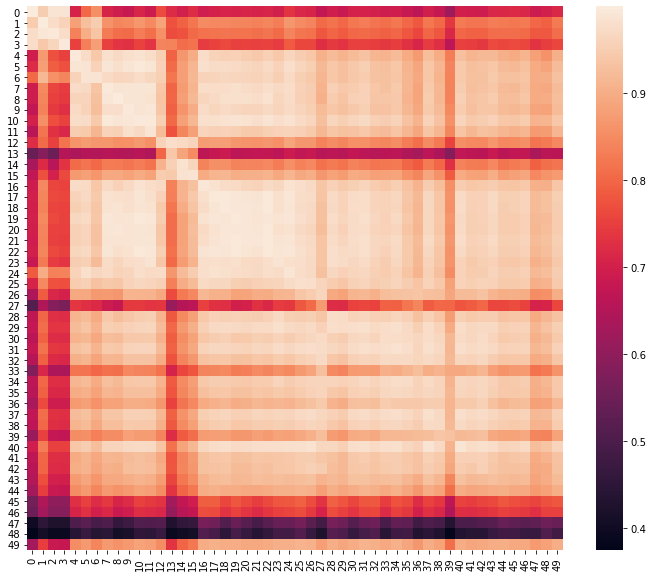

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 10))
ax = sns.heatmap(cka_all_scores)
plt.show()